In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import squidpy as sq
from scipy.spatial.distance import pdist, squareform
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import tabulate
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import umap
from importlib import reload
from scipy import stats

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3
import gget

# locals
import utils as ut
reload(ut)

2022-11-21 10:22:53.630705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 10:22:53.764965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-11-21 10:22:53.764988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 10:22:53.790312: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:22:54.6445

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [3]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [4]:
keys = ['ND', 'HFD8', 'HFD14']

alpha = 0.05
lft = 0

ligands = []
receptors = []

for k in keys:
    
    df = cf[cf['key'] == k]
    
    for cid in df['clusterId'].unique():
        
        cdf = df[(df['clusterId'] == cid) & (df['pvals'] < alpha)]
        cType = cdf['cellType'].unique()[0]
        
        # get ligands per cell type
        mask = cdf['gene'].isin(lr['ligand'])
        t = cdf[mask]
        t = t[t['logfoldchanges'] > lft]
        t = t.sort_values(by='logfoldchanges', ascending=False)
        ligands.append(t)    
        
        # get receptors per cell type
        mask = cdf['gene'].isin(lr['receptor'])
        t = cdf[mask]
        t = t[t['logfoldchanges'] > lft] 
        t = t.sort_values(by='logfoldchanges', ascending=False)
        receptors.append(t)            
    
ligands = pd.concat(ligands, ignore_index=True)
receptors = pd.concat(receptors, ignore_index=True)


sumL = pd.DataFrame(ligands[['key', 'cellType']].value_counts().reset_index())
sumL = sumL.sort_values(by=['key', 0], ascending=False)
sumR = pd.DataFrame(receptors[['key', 'cellType']].value_counts().reset_index())
sumR = sumR.sort_values(by=['key', 0], ascending=False)


print(tabulate.tabulate(sumL, 
                        headers=['Time', "Cell Type", "Ligands"], 
                        tablefmt='simple',
                        showindex=False))
print()
print(tabulate.tabulate(sumR, 
                        headers=['Time', "Cell Type", "Receptors"],
                        tablefmt='simple',
                        showindex=False))

Time    Cell Type          Ligands
------  ---------------  ---------
ND      Macrophages            250
ND      Stromal cells          121
ND      Monocytes              106
ND      Dendritic cells         97
ND      B cells                 66
ND      T cells                 62
ND      NK cells                46
HFD8    Macrophages            651
HFD8    T cells                265
HFD8    Dendritic cells        212
HFD8    Monocytes              168
HFD8    Stromal cells          111
HFD8    NK cells                63
HFD8    B cells                 26
HFD14   Macrophages            641
HFD14   Dendritic cells        145
HFD14   Stromal cells          119
HFD14   Monocytes               84
HFD14   NK cells                56
HFD14   T cells                 54
HFD14   B cells                 33

Time    Cell Type          Receptors
------  ---------------  -----------
ND      Macrophages              278
ND      Dendritic cells          129
ND      Monocytes                124
ND      S

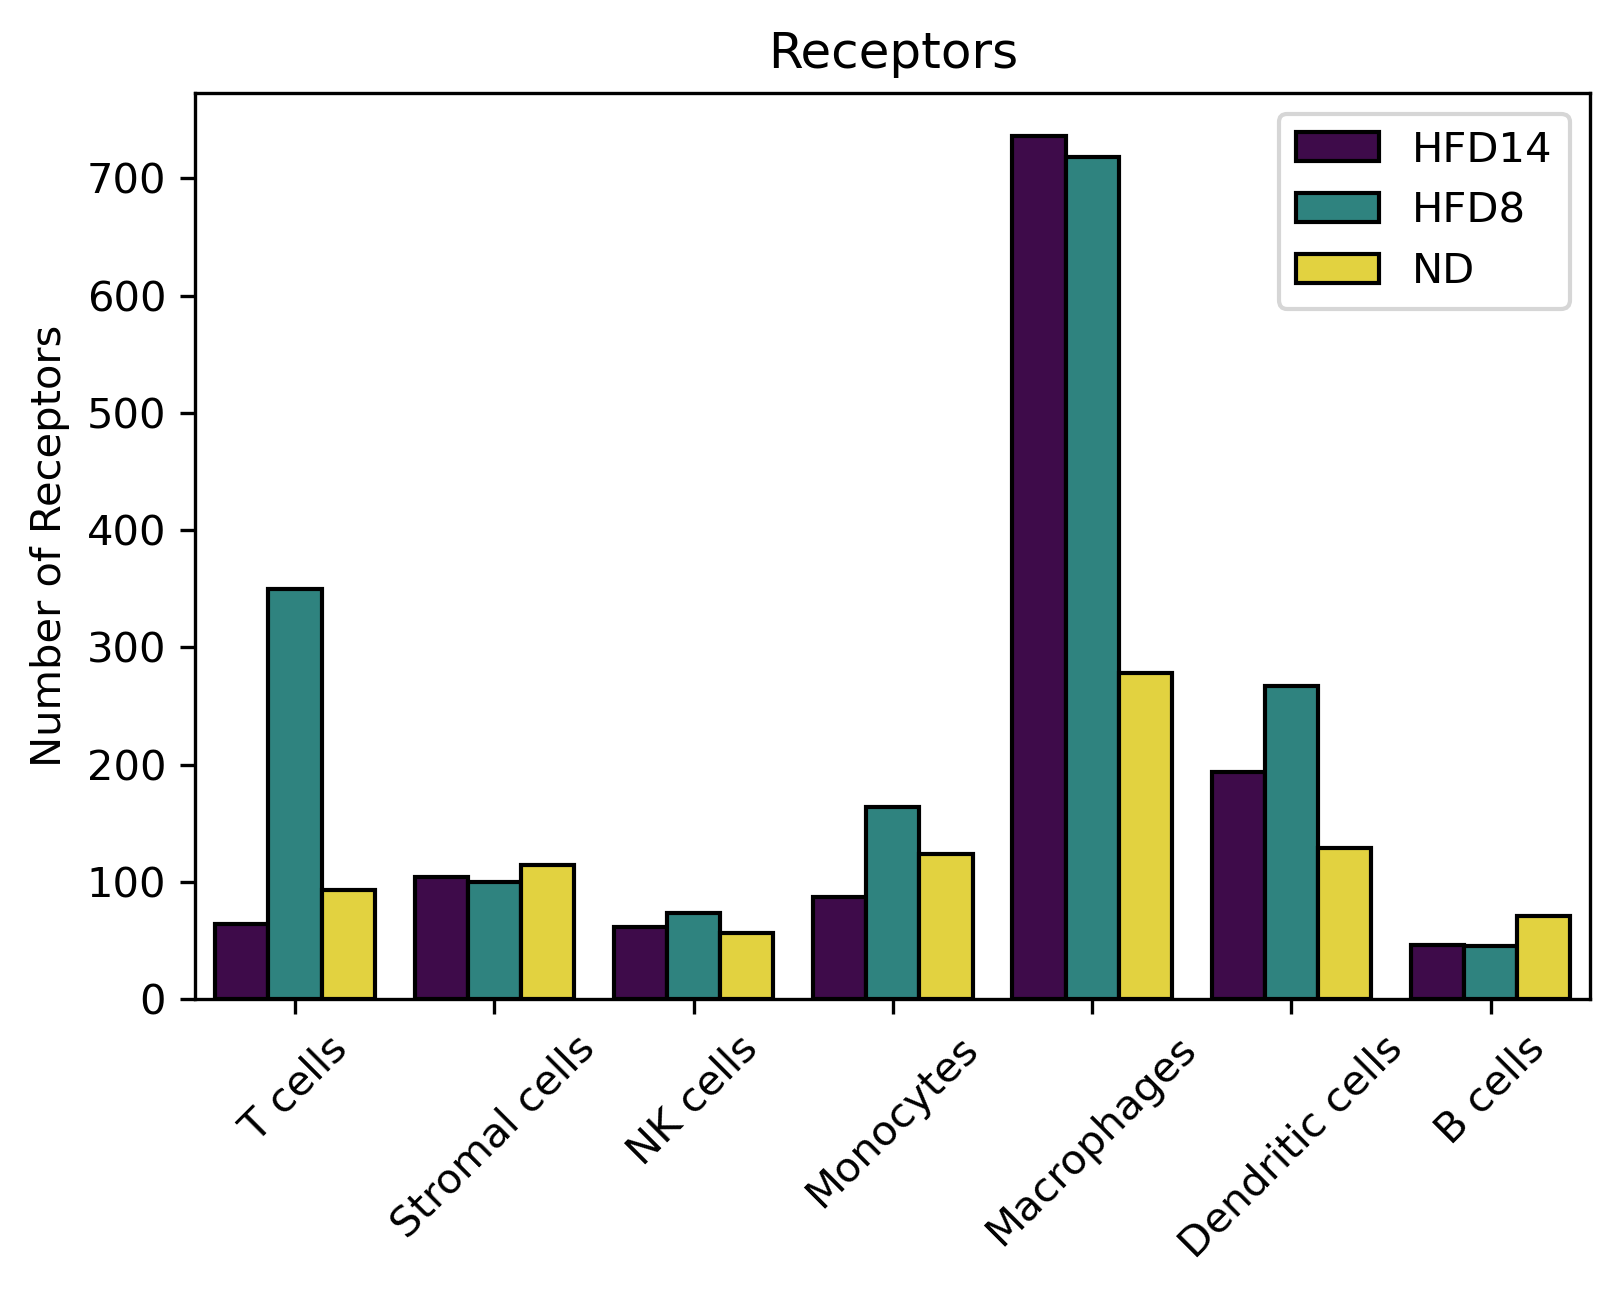

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['figure.facecolor'] = 'w'

colorlist = ut.ncolor(3, cmap='viridis')

plttr = sumR.sort_values(by=['key', 'cellType'], ascending=[True, False])

sns.barplot(data=plttr,
            x='cellType',
            y=0,
            edgecolor='k',
            palette=colorlist,
            hue='key')

_ = plt.xticks(rotation=45)
plt.ylabel('Number of Receptors')
plt.title("Receptors")
plt.xlabel("")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])

In [59]:
cellType = 'Macrophages'
lft = 0

# get all ligand/receptors
ligands = set(lr['ligand'].to_list())
receptors = set(lr['receptor'].to_list())

# get cell type specific upregulated genes
df = cf[(cf['cellType'] == cellType) & (cf['logfoldchanges'] > lft)]

res = []

for key in keys:
    
    # get all L/Rs expressed for cell type at time t
    ctGenes = set(df[df['key'] == key]['gene'].to_list())    
    ctLigands = ligands.intersection(ctGenes)
    ctReceptors = receptors.intersection(ctGenes)
    
    print(key, cellType, "L:", len(ctLigands), "R:", len(ctReceptors))
    
    for cType in cf['cellType'].unique():
        if not cType == cellType:
            cdf = cf[(cf['key'] == key) & (cf['cellType'] == cType)]
            otherGenes = set(cdf['gene'].to_list())
            
            otherLigands = ligands.intersection(otherGenes)
            otherReceptors = receptors.intersection(otherGenes)
            
            """ Cell Type ligands to other receptors """
            matches = lr[(lr['ligand'].isin(ctLigands)) & (lr['receptor'].isin(otherReceptors))]
            matches = matches[['ligand', 'receptor', 'Ligand.CC']]
            matches['ligand_cType'] = cellType
            matches['receptor_cType'] = cType
            matches['key'] = key
            res.append(matches)
            
            """ Cell type receptors and other ligands """
            matches = lr[(lr['ligand'].isin(otherLigands)) & (lr['receptor'].isin(ctReceptors))]
            matches = matches[['ligand', 'receptor', 'Ligand.CC']]
            matches['ligand_cType'] = cType
            matches['receptor_cType'] = cellType
            matches['key'] = key
            res.append(matches)

    
res = pd.concat(res, ignore_index=True)
print(res['Ligand.CC'].value_counts())
res.head()
outpath = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/{cellType}_LR.csv"
res.to_csv(outpath)
res.head()

ND Macrophages L: 160 R: 187
HFD8 Macrophages L: 221 R: 251
HFD14 Macrophages L: 210 R: 244
Secreted    6229
Membrane    4213
ECM         1576
Both         550
Other         41
Name: Ligand.CC, dtype: int64


,ligand,receptor,Ligand.CC,ligand_cType,receptor_cType,key
0,ADGRE5,CD55,Membrane,Macrophages,B cells,ND
1,ALCAM,CD6,Membrane,Macrophages,B cells,ND
2,ALCAM,L1CAM,Membrane,Macrophages,B cells,ND
3,APOE,LDLR,Secreted,Macrophages,B cells,ND
4,APOE,LRP1,Secreted,Macrophages,B cells,ND


In [97]:
d = res[['ligand_cType', 'receptor_cType', 'key']].value_counts().reset_index()
d = d.sort_values(by=['key', 'ligand_cType', 'receptor_cType'], ascending=[False, True, True])
d.columns = ['Cell Type Ligand', 'Cell Type Receptor', 'key', 'Pairs']

p = pd.pivot_table(d, index=['Cell Type Ligand', 'Cell Type Receptor'],values='Pairs', columns='key')
p = p.reset_index()
p = p[['Cell Type Ligand', 'Cell Type Receptor', 'ND', 'HFD8', 'HFD14']]
print(tabulate.tabulate(p, 
                        headers=p.columns, 
                        tablefmt='latex', 
                        showindex=False))

\begin{tabular}{llrrr}
\hline
 Cell Type Ligand   & Cell Type Receptor   &   ND &   HFD8 &   HFD14 \\
\hline
 B cells            & Macrophages          &  345 &    405 &     412 \\
 Dendritic cells    & Macrophages          &  346 &    477 &     434 \\
 Macrophages        & B cells              &  290 &    334 &     335 \\
 Macrophages        & Dendritic cells      &  283 &    394 &     367 \\
 Macrophages        & Monocytes            &  288 &    400 &     365 \\
 Macrophages        & NK cells             &  196 &    336 &     292 \\
 Macrophages        & Stromal cells        &  231 &    373 &     275 \\
 Macrophages        & T cells              &  250 &    401 &     310 \\
 Monocytes          & Macrophages          &  342 &    479 &     432 \\
 NK cells           & Macrophages          &  244 &    395 &     368 \\
 Stromal cells      & Macrophages          &  265 &    453 &     327 \\
 T cells            & Macrophages          &  307 &    478 &     380 \\
\hline
\end{tabular}


In [132]:
"""All vs all """

lft = 0
alpha = 0.05

# get all ligand/receptors
ligands = set(lr['ligand'].to_list())
receptors = set(lr['receptor'].to_list())

# get all up-regulated genes
df = cf[(cf['logfoldchanges'] > lft) & (cf['pvals'] < alpha)]

res = []

for key in keys:
    
    kdf = df[df['key'] == key]
    
    types = cf['cellType'].unique()
    
    
    for ci in types:
        for cj in types:
            
            # extract cell type specific genes
            ciGenes = kdf[kdf['cellType'] == ci]['gene'].to_list()
            cjGenes = kdf[kdf['cellType'] == cj]['gene'].to_list()
            
            ciL = ligands.intersection(ciGenes)
            ciR = receptors.intersection(ciGenes)
            
            cjL = ligands.intersection(cjGenes)
            cjR = receptors.intersection(cjGenes)
            
            """ ciL vs cjR """
            matches = lr[(lr['ligand'].isin(ciL)) & (lr['receptor'].isin(cjR))]
            matches = matches[['ligand', 'receptor', 'Ligand.CC']]
            matches['ligand_cType'] = ci
            matches['receptor_cType'] = cj
            matches['key'] = key
            res.append(matches)
            
            """ ciR vs cjL """
            matches = lr[(lr['ligand'].isin(cjL)) & (lr['receptor'].isin(ciR))]
            matches = matches[['ligand', 'receptor', 'Ligand.CC']]
            matches['ligand_cType'] = cj
            matches['receptor_cType'] = ci
            matches['key'] = key
            res.append(matches)
     
    
res = pd.concat(res, ignore_index=True)
print(res['Ligand.CC'].value_counts())
res.head()
outpath = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/all_LR.csv"
res.to_csv(outpath)
res.head()

Secreted    6584
Membrane    6364
ECM         1938
Both         428
Other         30
Name: Ligand.CC, dtype: int64


,ligand,receptor,Ligand.CC,ligand_cType,receptor_cType,key
0,ADGRE5,CD55,Membrane,Macrophages,Macrophages,ND
1,ALCAM,L1CAM,Membrane,Macrophages,Macrophages,ND
2,APOE,LDLR,Secreted,Macrophages,Macrophages,ND
3,APOE,LRP1,Secreted,Macrophages,Macrophages,ND
4,APOE,LRP5,Secreted,Macrophages,Macrophages,ND


In [133]:
d = res[['ligand_cType', 'receptor_cType', 'key']].value_counts().reset_index()
d = d.sort_values(by=['key', 'ligand_cType', 'receptor_cType'], ascending=[False, True, True])
d.columns = ['Cell Type Ligand', 'Cell Type Receptor', 'key', 'Pairs']

p = pd.pivot_table(d, index=['Cell Type Ligand', 'Cell Type Receptor'],values='Pairs', columns='key')
p = p.reset_index()
p = p[['Cell Type Ligand', 'Cell Type Receptor', 'ND', 'HFD8', 'HFD14']]
p.head()

key,Cell Type Ligand,Cell Type Receptor,ND,HFD8,HFD14
0,B cells,B cells,46,18,24
1,B cells,Dendritic cells,40,30,26
2,B cells,Macrophages,108,48,46
3,B cells,Monocytes,76,32,16
4,B cells,NK cells,22,20,24


Text(0.5, 1.0, 'HFD14')

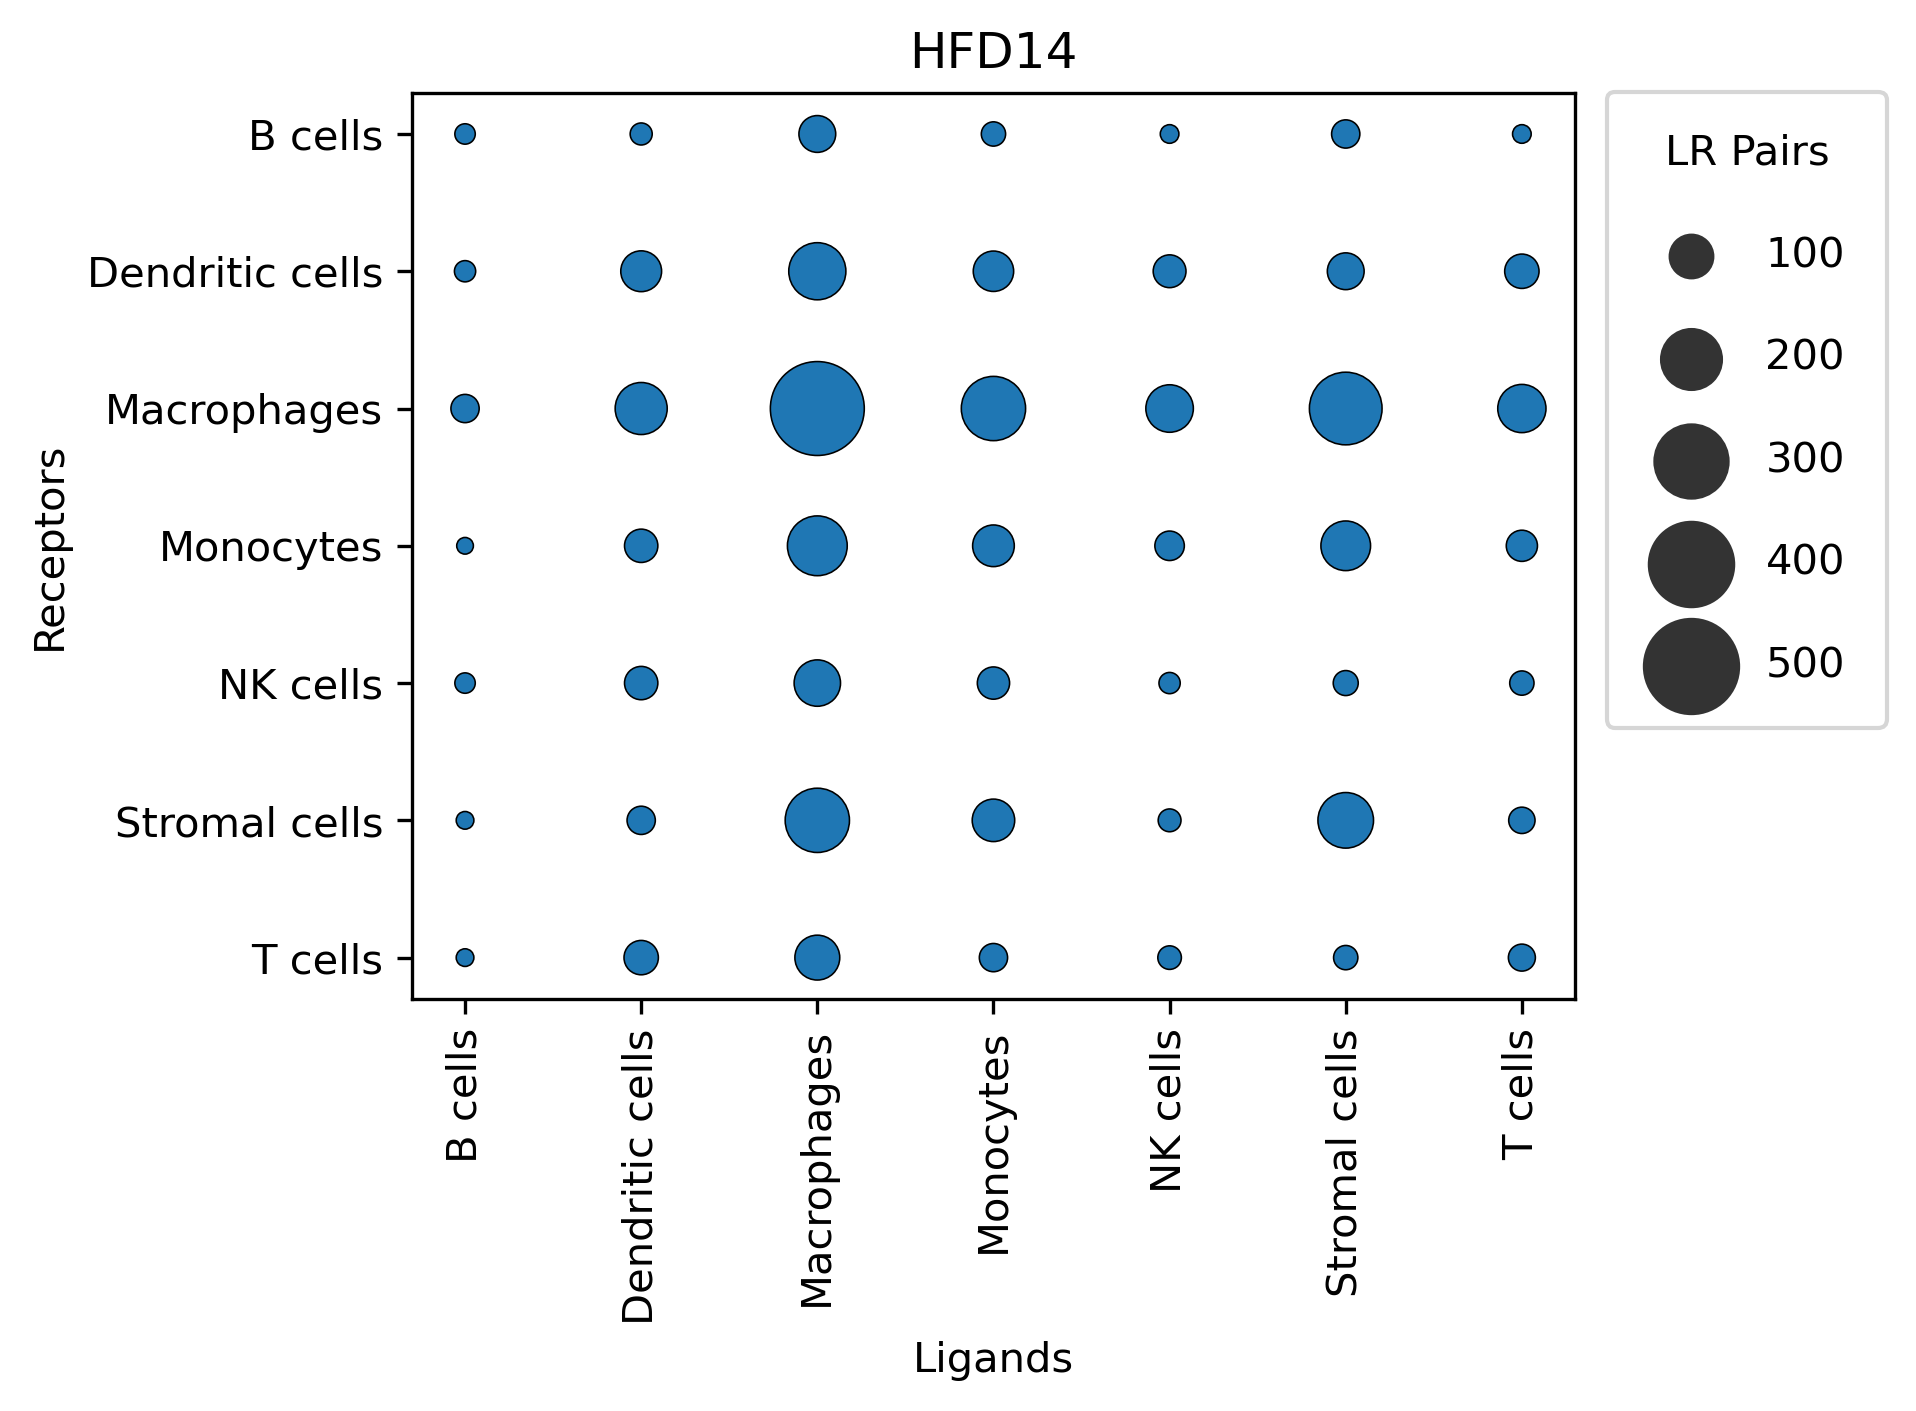

In [200]:
time = "HFD14"

# sizes = [x/p[time].sum() for x in p[time]]
sizes = p[time]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['figure.facecolor'] = "w"

g = sns.scatterplot(data=p,
                    x='Cell Type Ligand',
                    y='Cell Type Receptor',
                    sizes=(np.min(sizes), np.max(sizes)),
                    edgecolor='k',
                    size=sizes)

plt.ylabel('Receptors')
plt.xlabel('Ligands')
_ = plt.xticks(rotation=90)
g.legend(loc='center left',
         bbox_to_anchor=(1.01, 0.65), 
         ncol=1, 
         labelspacing = 1.5,
         borderpad = 1,
         title='LR Pairs')

plt.title(time)

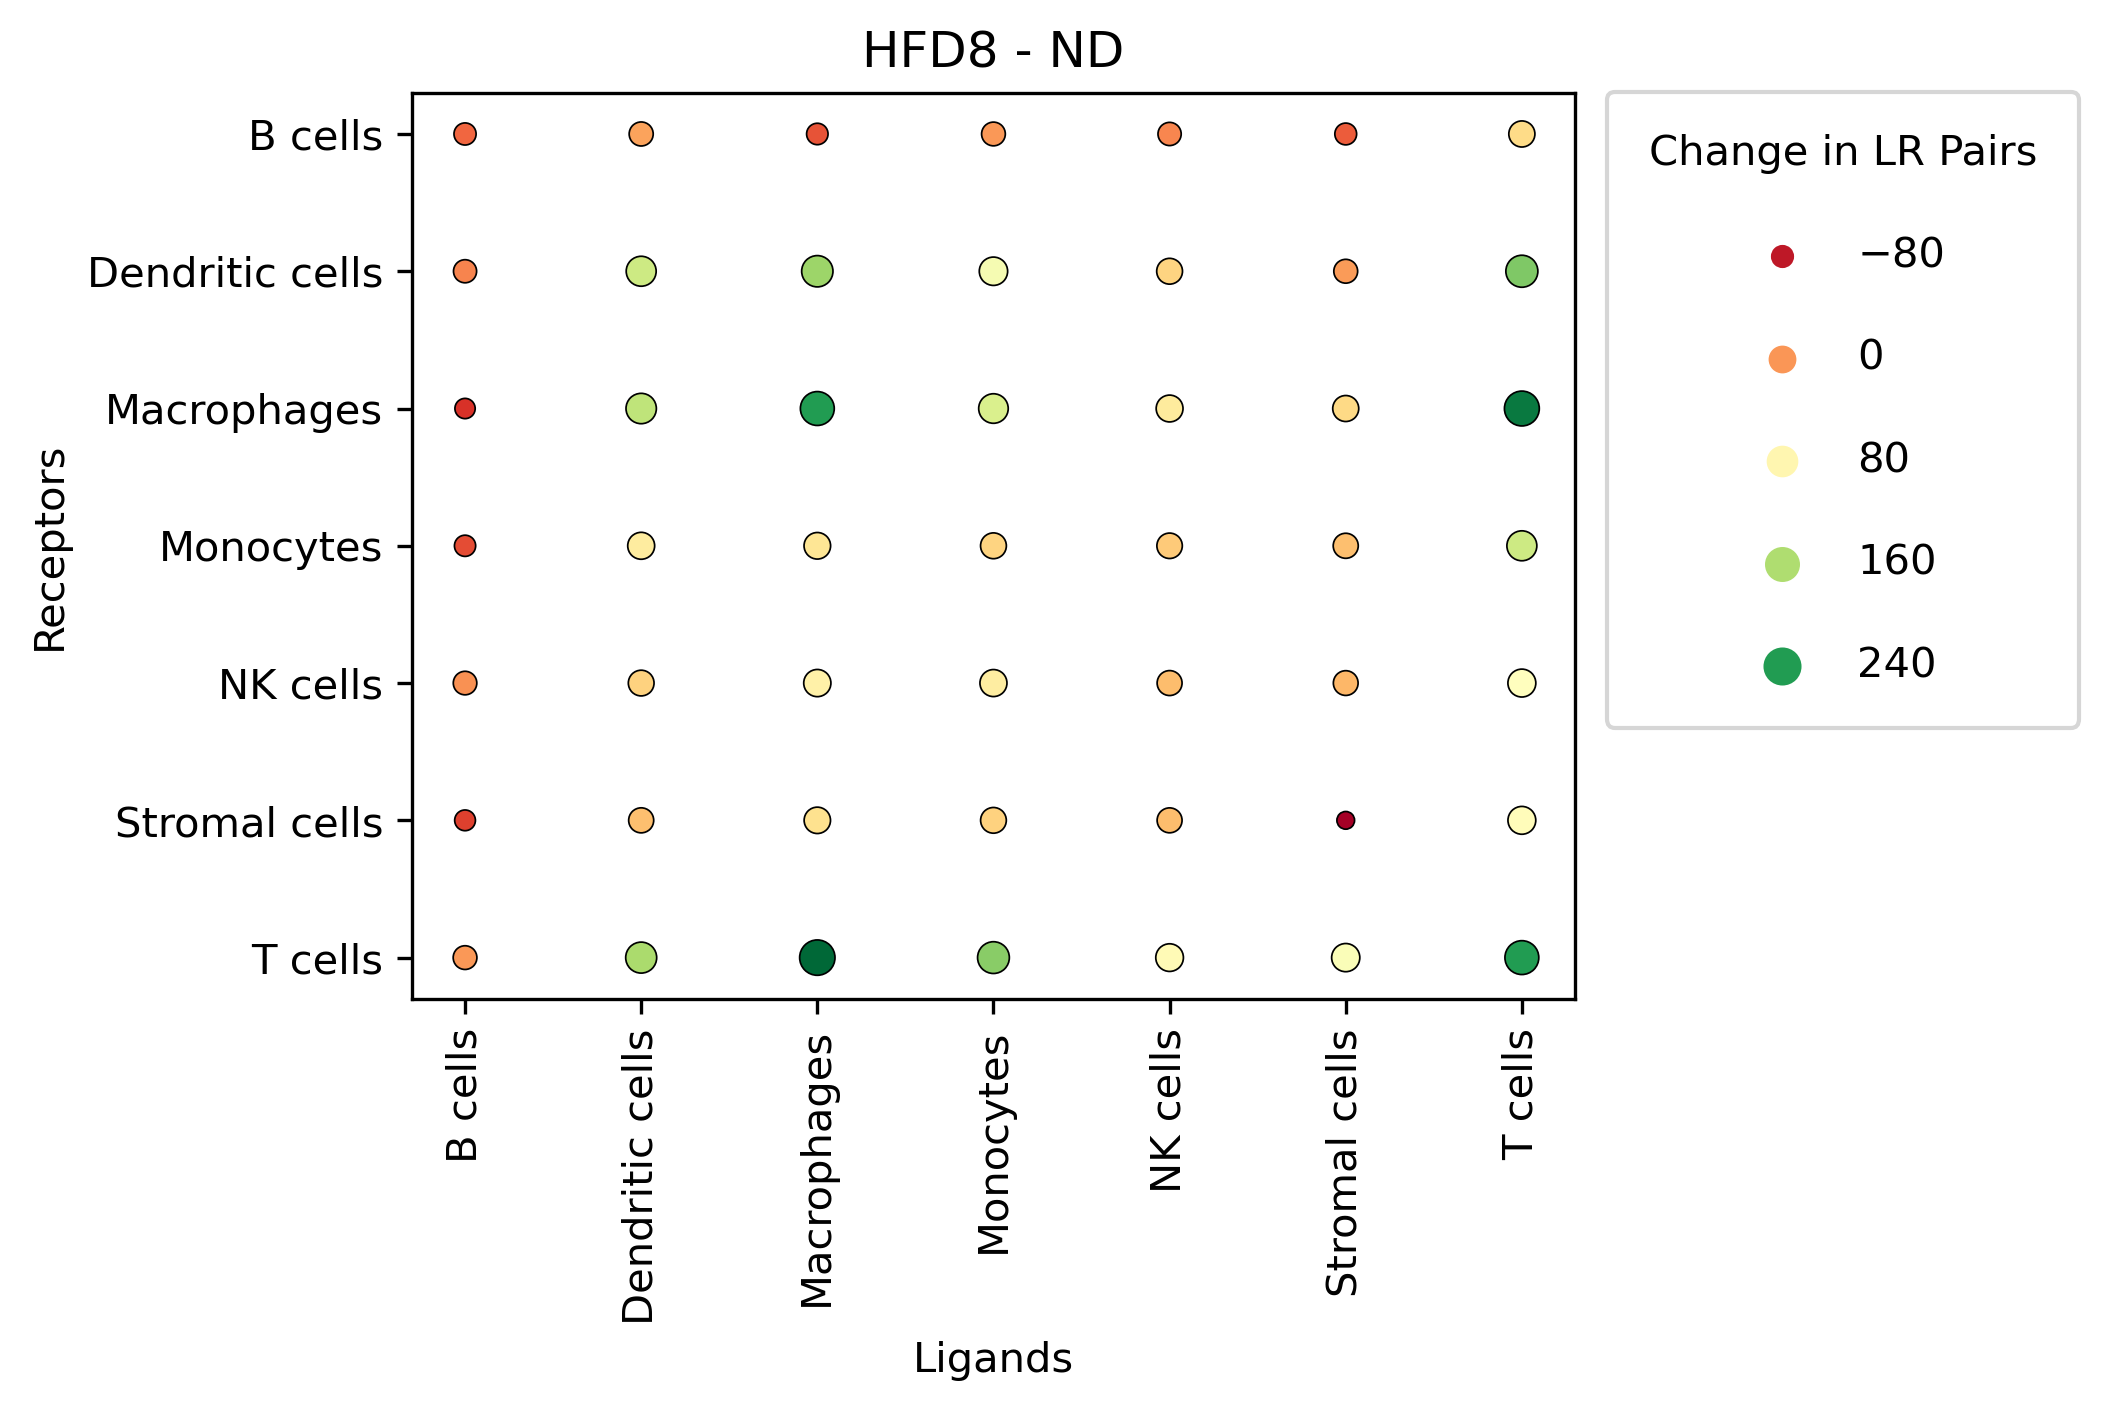

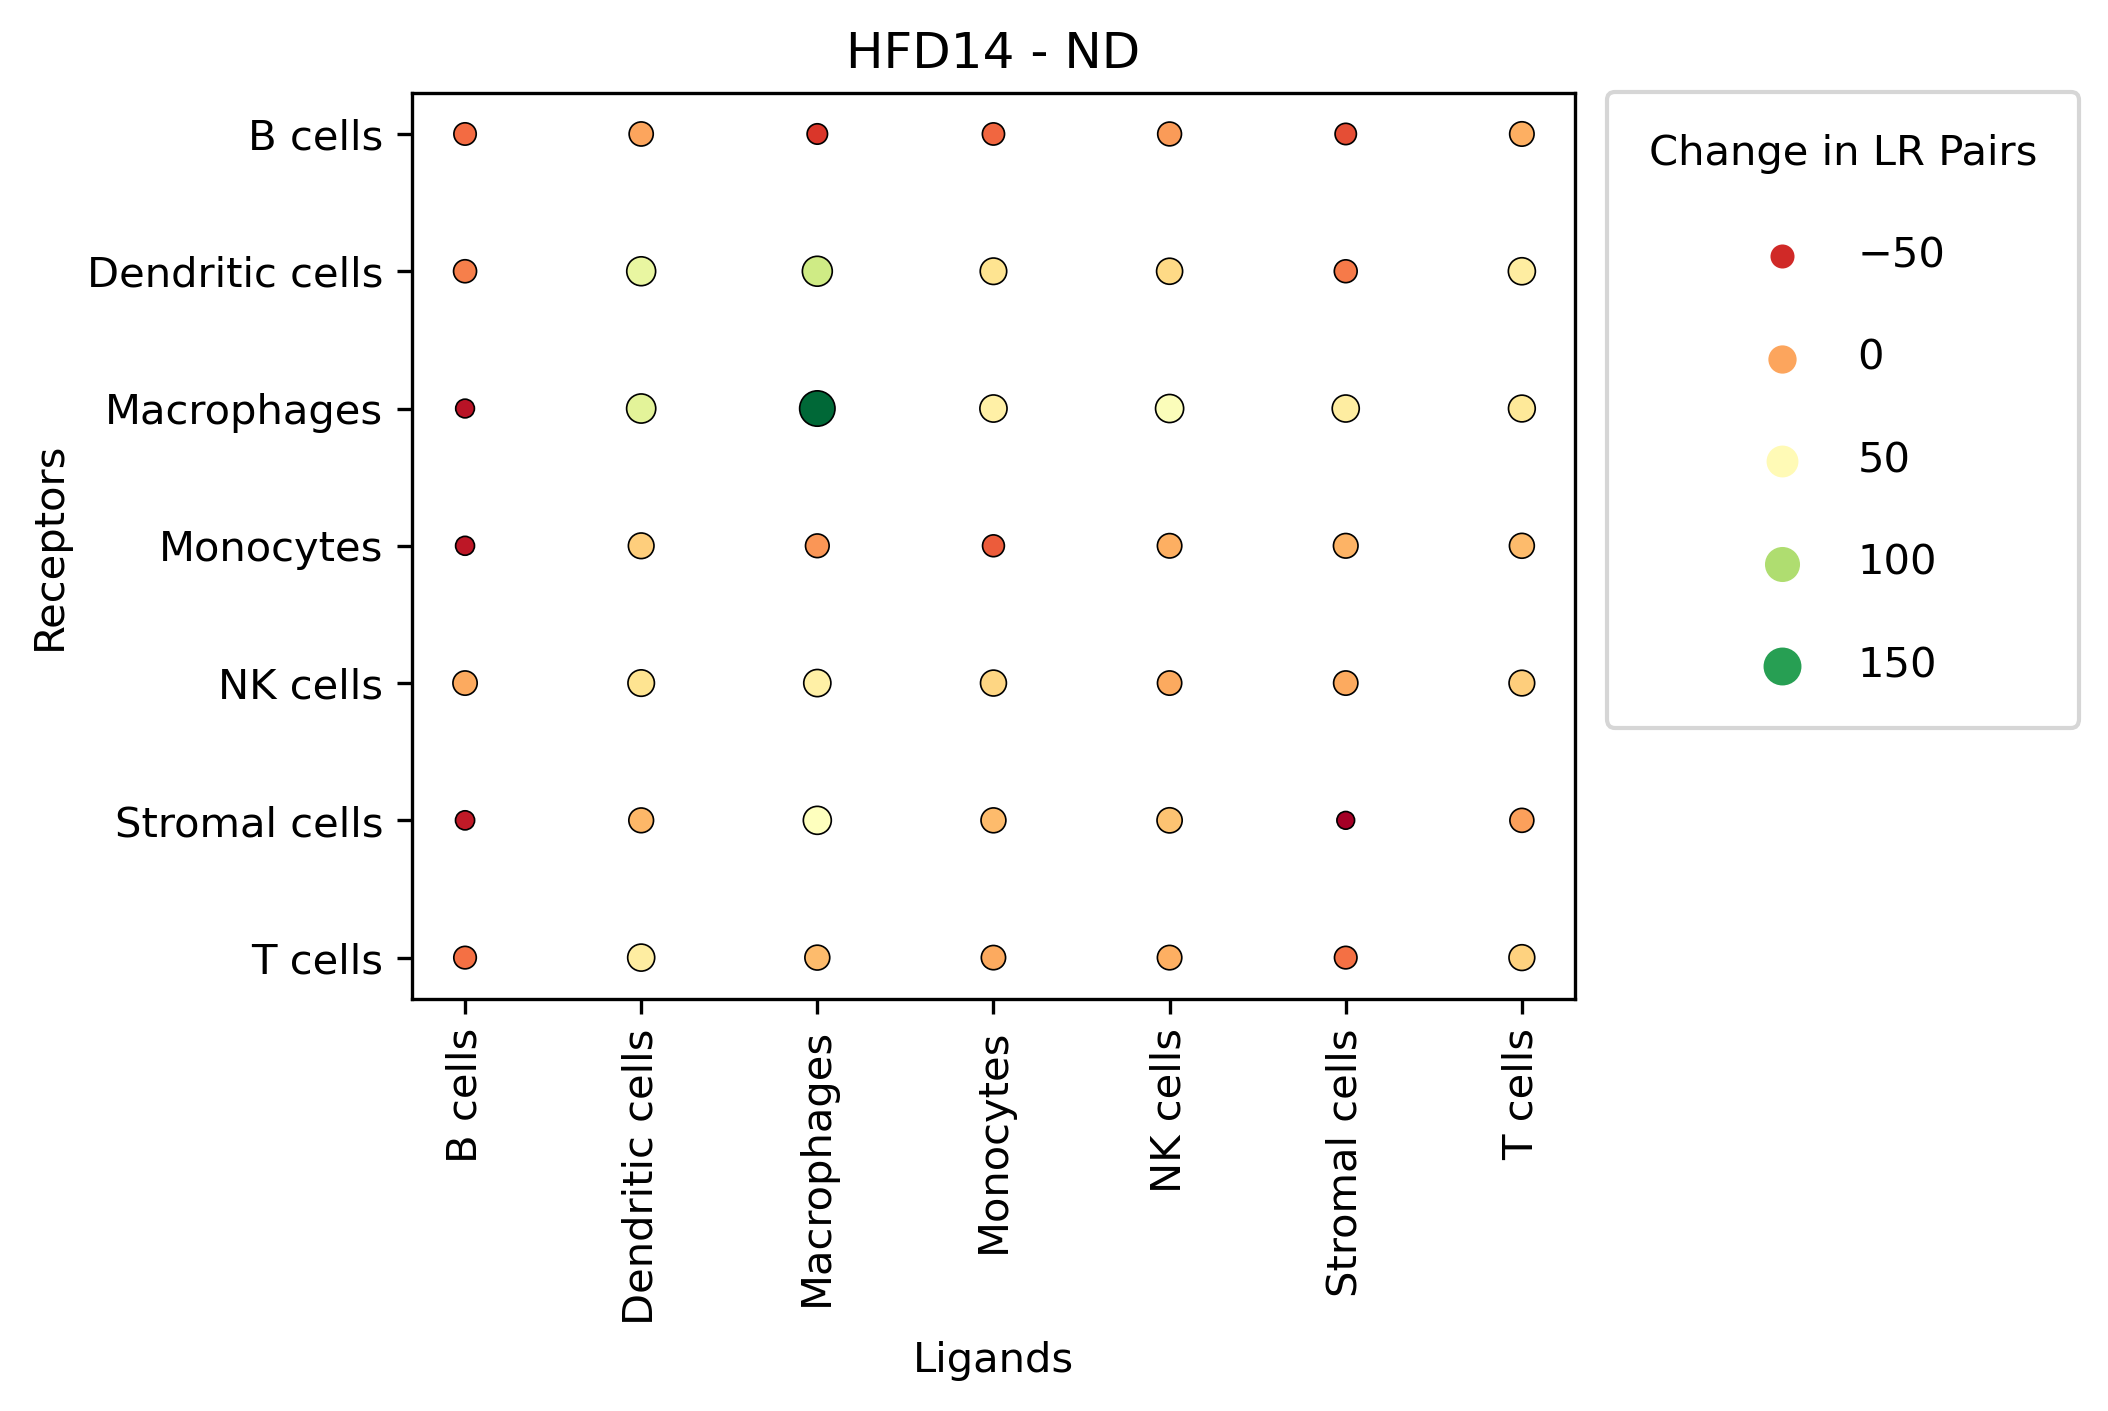

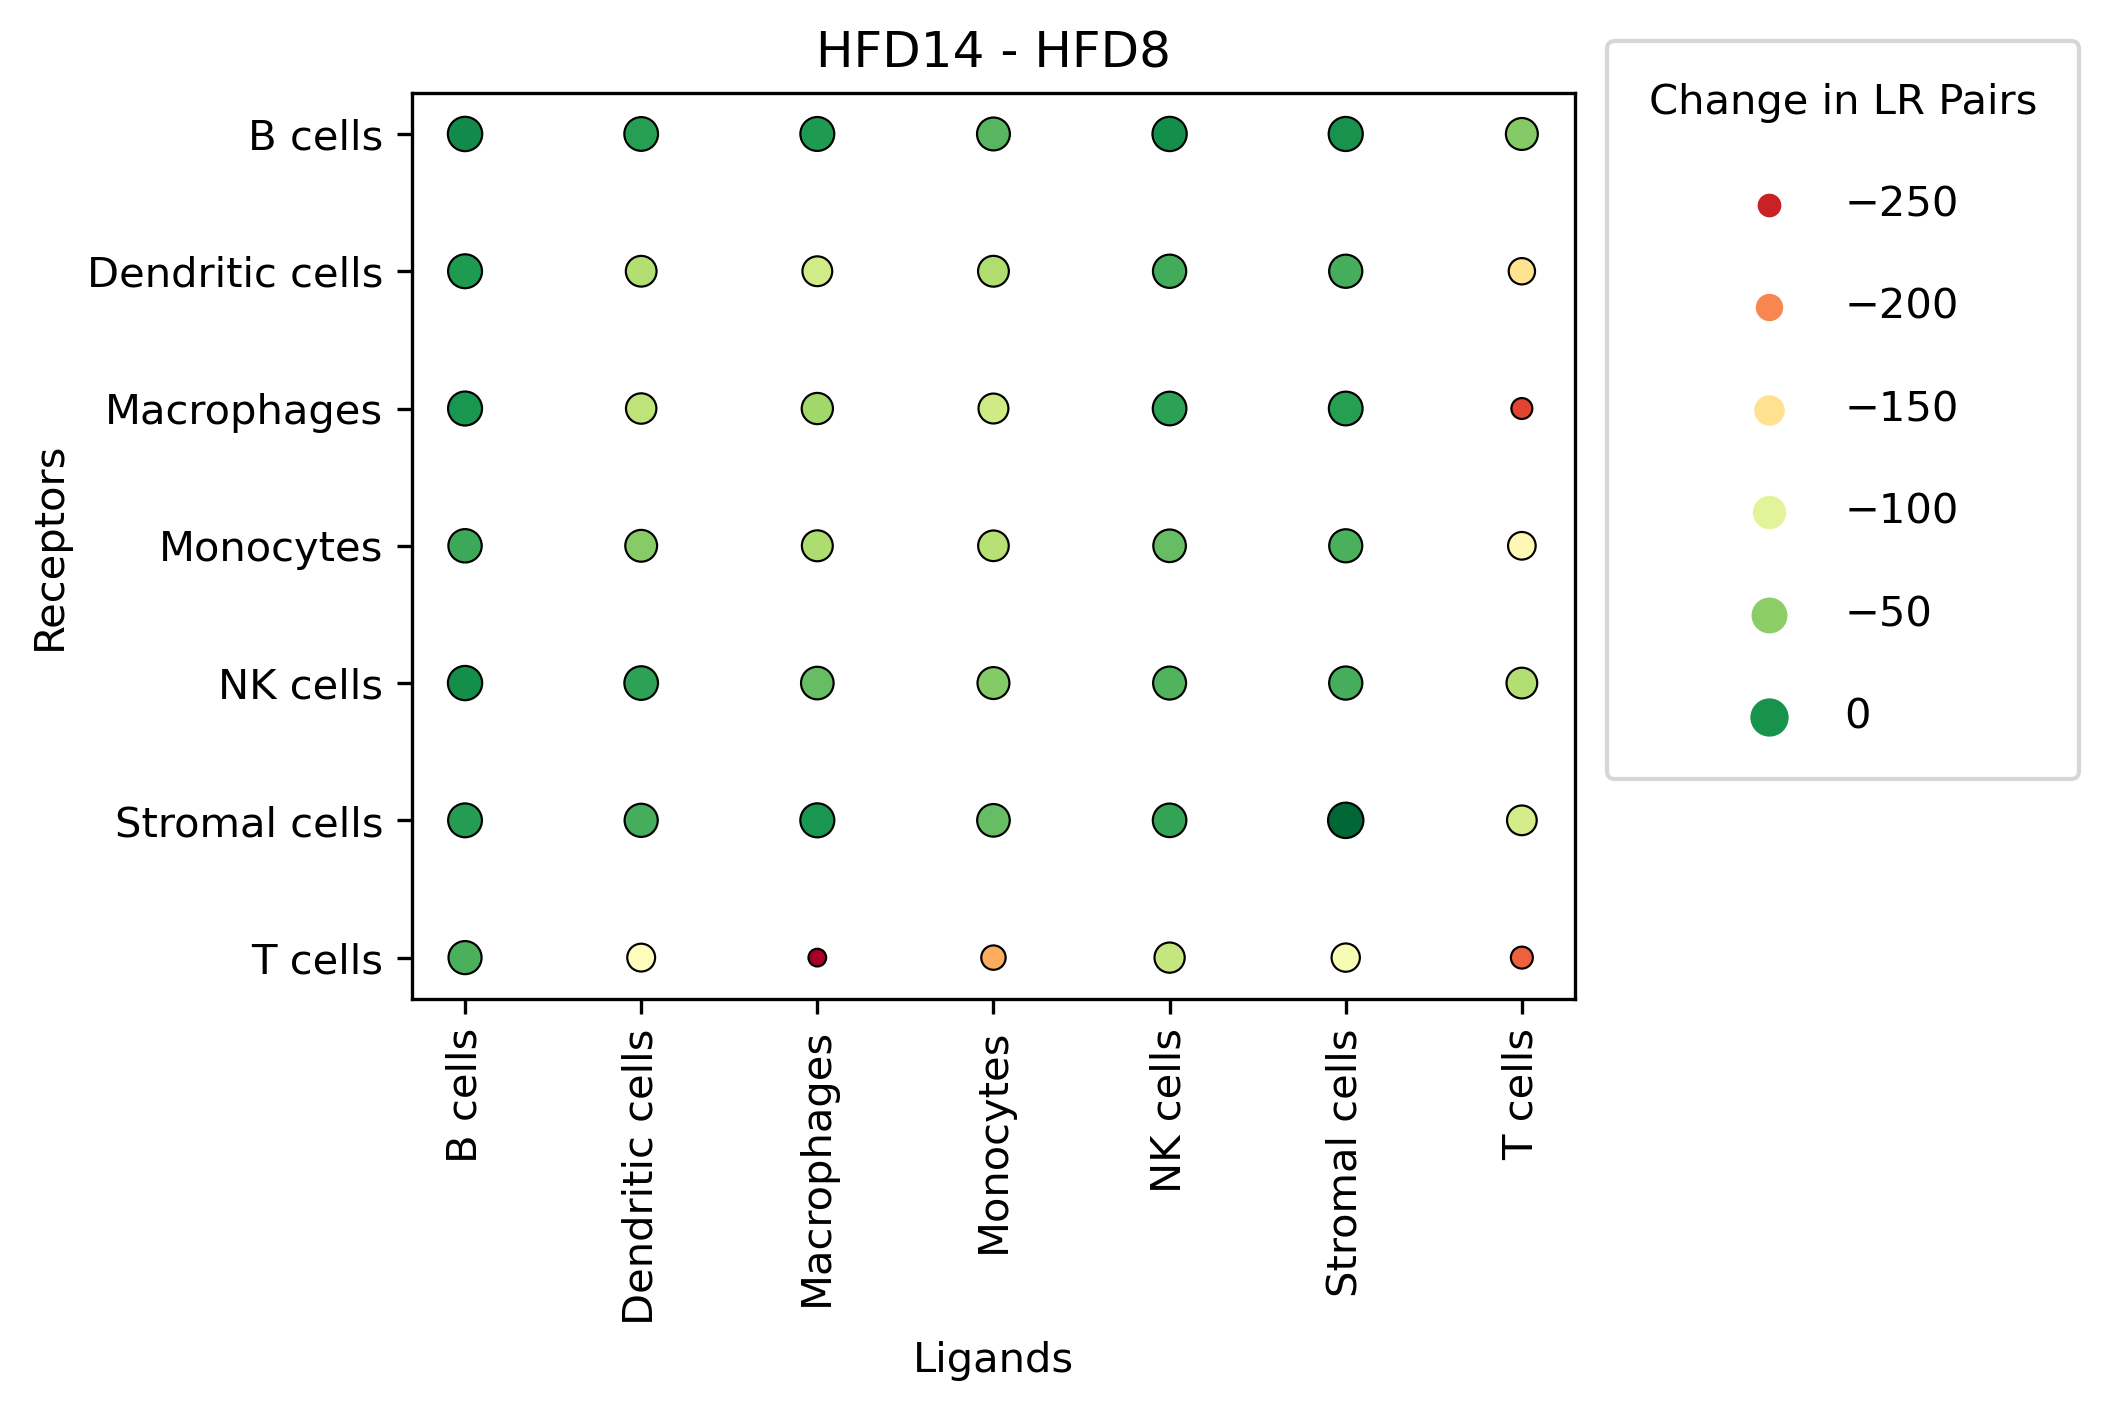

In [226]:
keys = ['ND', 'HFD8', 'HFD14']

comps = list(itertools.combinations(keys, 2))

for col1, col2 in comps:
    p1 = p[col1]
    p2 = p[col2]
    
    diffs = p2 - p1
    diffs = diffs.astype(float).to_numpy()
    
    colors = np.where(diffs < 0, "r", "g")
    
    
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 5, 4
    plt.rcParams['figure.facecolor'] = "w"

    g = sns.scatterplot(data=p,
                        x='Cell Type Ligand',
                        y='Cell Type Receptor',
                        hue=diffs, 
                        edgecolor='k',
                        palette='RdYlGn',
                        size=diffs)

    plt.ylabel('Receptors')
    plt.xlabel('Ligands')
    _ = plt.xticks(rotation=90)
    g.legend(loc='center left',
             bbox_to_anchor=(1.01, 0.65), 
             ncol=1, 
             labelspacing = 1.5,
             borderpad = 1,
             title='Change in LR Pairs')
    
    plt.title(f"{col2} - {col1}")
    plt.show()

